In [ ]:
# INSTALL Python3, CONDA, JUPYTER

# MAIN LIBRARIES USED:
# MNE
# MNE_FEATURES
# PYTHON MULTIPROCESSING, CONCURRENT, TIME
import numpy as np

In [9]:
## READ A SAMPLE FILE TO EXTRACT SAMPLING FREQUENCY
import mne
import mne_features

mcifile=mne.io.read_raw_eeglab("/home/venkat/Downloads/submission/ClassifierTestsample/aMCI/CAUH_298.set")


/home/venkat/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/venkat/miniconda3/lib/python3.6/site-packages/mne_features/mock_numba.py:12: UserWarning: Numba not found. Your code will be slower.
  warn('Numba not found. Your code will be slower.')
/home/venkat/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/venkat/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to 

In [10]:
mcifile

<RawEEGLAB  |  CAUH_298.set, n_channels x n_times : 19 x 11990 (59.9 sec), ~1.8 MB, data loaded>

In [11]:
# CREATE FOLDER NAMED 'all'
# COPY BOTH /Normal and /aMCI FILES INTO /all

import os
from pathlib import Path
import mne as mne

allfolder="/home/venkat/Downloads/submission/ClassifierTestsample/all/"

allfiles = os.listdir(allfolder)
allfiles1=[]
for fi in allfiles:
    fn=(os.path.join('/home/venkat/Downloads/submission/ClassifierTestsample/all/', fi))
    f=mne.io.read_raw_eeglab(fn)
    allfiles1.append(f)

<ipython-input-11-d023e05c39cd>:14: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  f=mne.io.read_raw_eeglab(fn)
<ipython-input-11-d023e05c39cd>:14: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  f=mne.io.read_raw_eeglab(fn)
<ipython-input-11-d023e05c39cd>:14: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  f=mne.io.read_raw_eeglab(fn)
<ipython-input-11-d023e05c39cd>:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  f=mne.io.read_raw_eeglab(fn)
<ipython-input-11-d023e05c39cd>:14: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  f=mne.io.read_raw_eeg

In [ ]:
print(allfiles1[0].info['sfreq'])

In [ ]:
allfiles1[0].n_times

In [13]:
fn=(os.path.join('/home/venkat/Downloads/submission/ClassifierTestsample/all/', allfiles[0]))
f=mne.io.read_raw_eeglab(fn)
columns=f.ch_names
print(columns)

['Fp1-AVG', 'F3-AVG', 'C3-AVG', 'P3-AVG', 'O1-AVG', 'Fp2-AVG', 'F4-AVG', 'C4-AVG', 'P4-AVG', 'O2-AVG', 'F7-AVG', 'T3-AVG', 'T5-AVG', 'F8-AVG', 'T4-AVG', 'T6-AVG', 'FZ-AVG', 'CZ-AVG', 'PZ-AVG']


<ipython-input-13-aa808821a290>:2: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  f=mne.io.read_raw_eeglab(fn)


In [12]:
# specific frequency bands
FREQ_BANDS = {"delta": [0.5, 4.5],"theta": [4.5, 8.5],"alpha": [8.5, 11.5],"sigma": [11.5, 15.5],
                  "beta": [15.5, 30], "all": [0.5,45]}

In [ ]:
# MAKE FIXED LENGTH EPOCHS
epochs_data=[]
epochs=[]
for f in allfiles1:
    events = mne.make_fixed_length_events(f, id=1, duration=4.)
    epochs_train = mne.Epochs(f, events, tmin=0., tmax=4., baseline=None, reject=None, preload=True)
    epochs_data.append(epochs_train.get_data())
    epochs.append(epochs_train)

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf
       
    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp = bp/simps(psd, dx=freq_res)
    return bp

In [ ]:
# COMPUTE ABSOLUTE AND RELATIVE BAND POWER
from scipy.fftpack import fft,fft2, fftshift

def calculate_band_powers(filenum,electrode, band):
    
    epoch_data = epochs_data[filenum]
    nepochs=len(epoch_data)
    channels=len(epoch_data[0])
    timepoints=len(epoch_data[0][0])
    
    alist = []
    for i in range(nepochs):  # number of epochs
        for j in range(channels): # number of electrodes
            if(j==electrode):
                for k in range(timepoints): # number of time points in epoch
                    alist.append(epoch_data[i][j][k])

    electrode=np.reshape(alist, (nepochs,timepoints))
    bp_sum=0
    for epoch in electrode:
        bp_sum+=bandpower(epoch, allfiles1[filenum].info['sfreq'], FREQ_BANDS[band], None, False)

    avg_bp_sum=bp_sum/nepochs
    return avg_bp_sum

In [ ]:
# TYPE1 RELATIVE POWER
def RP1(file_num):
    band_power_by_electrode=band_power_all[file_num]
    relative_band_powers={}
    for band in FREQ_BANDS:
        if(band!="all"):
            arr=[]
            for i in range(19):
                for j in range(19):
                    if(i<j):
                        bp1=band_power_by_electrode[band][i]
                        bp2=band_power_by_electrode[band][j]

                        rp1=(bp1-bp2)/(bp1+bp2)
                        arr.append(rp1)
            relative_band_powers[band]=arr

    return relative_band_powers

In [ ]:
# TYPE2 RELATIVE POWER
def RP2(file_num):
    band_power_by_electrode=band_power_all[file_num]
    relative_band_powers={}
    for band in FREQ_BANDS:
        if(band!="all"):
            arr=[]
            for i in range(19):
                for j in range(19):
                    if(i<j):
                        bp1=band_power_by_electrode[band][i]
                        bp2=band_power_by_electrode[band][j]
                        tp=band_power_by_electrode["all"][i]
                        wp1=bp1/tp
                        wp2=bp2/tp
                        rp3=wp1-wp2/(wp1+wp2)
                        arr.append(rp3)
            relative_band_powers[band]=arr

    return relative_band_powers

In [ ]:

## TAKES LONG TIME - 19.085 seconds for all 20 files
import concurrent
import time

band_power_all={}

def process(j):
    band_power_by_electrode={}
    for band in FREQ_BANDS:
        arr=[]
        for i in range(19):
            arr.append(calculate_band_powers(j,i, band))
        band_power_by_electrode[band]=arr
    
    band_power_all[j]=band_power_by_electrode
    return j, band_power_all[j]

if __name__=='__main__':
    start = time.time()
    with concurrent.futures.ProcessPoolExecutor(8) as executor:
        for row, result in executor.map(process, range(0,20)):
            band_power_all[row] = result

    print(time.time()-start)


In [14]:
y=[None]*20
i=0
for fi in allfiles:
    fn=(os.path.join('/home/venkat/connectomes/ClassifierTestsample/all', fi))
    if(fi.startswith("C")):
        y[i]=1
    else:
        y[i]=0
    i=i+1

In [15]:
print(y)

[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]


In [ ]:
# RELATIVE TYPE3 POWER
# 
def RP3(file_num):
    band_power_by_electrode=band_power_all[file_num]
    relative_band_powers={}
    for band in FREQ_BANDS:
        if(band!="all"):
            arr=[]
            for i in range(19):
                for j in range(19):
                    if(i<j):
                        bp1=band_power_by_electrode[band][i]
                        bp2=band_power_by_electrode[band][j]

                        rp1=np.log(bp1)-np.log(bp2)
                        arr.append(rp1)
            relative_band_powers[band]=arr

    return relative_band_powers

In [ ]:
RP1_band_power={}
RP2_band_power={}
RP3_band_power={}

for file_num in range(20):
    RP1_band_power[file_num]=RP1(file_num)
    RP2_band_power[file_num]=RP2(file_num)
    RP3_band_power[file_num]=RP3(file_num)

In [ ]:
# PARALLEL COMPUTATION OF NON LINEAR FEATURES
# HIGUCHI FRACTAL DIMENSION
# !!!!!!!CAUTION - SPEED DEPENDS ON HARDWARE

## AS THIS STEP MAY TAKE LONG TIME, I HAVE (MANUALLY) WRITTEN THE
# RESULTS OF THESE FUNCTIONS INTO CSV FILES
# CALLED HIGUCHI.CSV AND APPROXENT.CSV

import concurrent
import time
import mne_features

features_higuchi = np.zeros((20, 19))

def calculate_higuchi(i):
    higuchi=mne_features.univariate.compute_higuchi_fd(allfiles1[i].get_data())
    print(allfiles1[i], '------>', higuchi)
    return i, higuchi

if __name__=='__main__':
    start = time.time();
    with concurrent.futures.ProcessPoolExecutor(8) as executor:
        for row, result in executor.map(calculate_higuchi, range(20)):
            features_higuchi[row] = result

    print(time.time()-start)

In [ ]:
# PARALLEL COMPUTATION OF NON LINEAR FEATURES
# APPROXIMATE ENTROPY
# !!!!!!!CAUTION - SPEED DEPENDS ON HARDWARE

import concurrent
import time

features_approx_ent = np.zeros((20, 19))

def calculate_approx_entropy(i):
    approx_entropy=mne_features.univariate.compute_app_entropy(allfiles1[i].get_data())
    print(allfiles1[i], '------>', approx_entropy)
    return i, approx_entropy

if __name__=='__main__':
    start = time.time();
    with concurrent.futures.ProcessPoolExecutor(8) as executor:
        for row, result in executor.map(calculate_approx_entropy, range(20)):
            features_approx_ent[row] = result

    print(time.time()-start)

In [ ]:
print(np.savetxt("higuchi_features.csv", features_higuchi, delimiter=","))

In [ ]:
X_beta_R1=np.zeros((20,171))
for key in RP1_band_power.keys():
    X_beta_R1[key,:]=RP1_band_power[key]['beta']
    
X_beta_R2=np.zeros((20,171))
for key in RP2_band_power.keys():
    X_beta_R2[key,:]=RP2_band_power[key]['beta']
    
X_beta_R3=np.zeros((20,171))
for key in RP3_band_power.keys():
    X_beta_R3[key,:]=RP3_band_power[key]['beta']

In [ ]:
# ALPHAS ARE NAN - WHY?

X_sigma_R1=np.zeros((20,171))
for key in RP1_band_power.keys():
    X_sigma_R1[key,:]=RP1_band_power[key]['sigma']
    
X_sigma_R2=np.zeros((20,171))
for key in RP2_band_power.keys():
    X_sigma_R2[key,:]=RP2_band_power[key]['sigma']
    
X_sigma_R3=np.zeros((20,171))
for key in RP3_band_power.keys():
    X_sigma_R3[key,:]=RP3_band_power[key]['sigma']

In [ ]:
X_theta_R1=np.zeros((20,171))
for key in RP1_band_power.keys():
    X_theta_R1[key,:]=RP1_band_power[key]['theta']
    
X_theta_R2=np.zeros((20,171))
for key in RP2_band_power.keys():
    X_theta_R2[key,:]=RP2_band_power[key]['theta']
    
X_theta_R3=np.zeros((20,171))
for key in RP3_band_power.keys():
    X_theta_R3[key,:]=RP3_band_power[key]['theta']

In [ ]:
# WHY ARE ALL ALPHAS ZERO?
X_alpha_R1=np.zeros((20,171))
for key in RP1_band_power.keys():
    X_alpha_R1[key,:]=RP1_band_power[key]['alpha']
    
X_alpha_R2=np.zeros((20,171))
for key in RP2_band_power.keys():
    X_alpha_R2[key,:]=RP2_band_power[key]['alpha']
    
X_alpha_R3=np.zeros((20,171))
for key in RP3_band_power.keys():
    X_alpha_R3[key,:]=RP3_band_power[key]['alpha']

In [ ]:
X_delta_R1=np.zeros((20,171))
for key in RP1_band_power.keys():
    X_beta_R1[key,:]=RP1_band_power[key]['beta']

X_delta_R2=np.zeros((20,171))
for key in RP2_band_power.keys():
    X_beta_R2[key,:]=RP2_band_power[key]['beta']
    
X_delta_R3=np.zeros((20,171))
for key in RP3_band_power.keys():
    X_beta_R3[key,:]=RP3_band_power[key]['beta']

In [ ]:
print(X_delta_R1)

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn import neighbors
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from mne_features.feature_extraction import FeatureExtractor

###############################################################################

pipe = Pipeline([('clf', RandomForestClassifier(n_estimators=100,max_depth=4,random_state=42))])
pipe_logistic=Pipeline([('clf', LogisticRegression(solver='lbfgs', max_iter=1000,multi_class='ovr'))])
pipe_knn = Pipeline([('clf', neighbors.KNeighborsClassifier())])
pipe_svc = Pipeline([('clf', svm.SVC(kernel='poly', gamma='auto', C=10.0))])
pipe_gb = Pipeline([('clf', GaussianNB())])
pipe_ridge = Pipeline([('clf', RidgeClassifier())])
pipe_lda=Pipeline([('clf', LinearDiscriminantAnalysis())])
pipe_qda=Pipeline([('clf', QuadraticDiscriminantAnalysis())])


skf = StratifiedKFold(n_splits=9, random_state=42)

###############################################################################
# Print the cross-validation accuracy score:
scores_randomforest = cross_val_score(pipe, X_delta_R2, y, cv=skf)
scores_logistic = cross_val_score(pipe_logistic, X_delta_R2, y, cv=skf)
scores_knn = cross_val_score(pipe_knn, X_delta_R2, y, cv=skf)
scores_svc = cross_val_score(pipe_svc, X_delta_R2, y, cv=skf)
scores_gb = cross_val_score(pipe_gb, X_delta_R2, y, cv=skf)
scores_ridge = cross_val_score(pipe_ridge, X_delta_R2, y, cv=skf)

scores_lda = cross_val_score(pipe_lda, X_delta_R2, y, cv=skf)
scores_qda = cross_val_score(pipe_qda, X_delta_R2, y, cv=skf)

print('Random forest accuracy = ' , (np.mean(scores_randomforest),np.std(scores_randomforest)))
print('Logistic regression accuracy = ' , (np.mean(scores_logistic),np.std(scores_logistic)))
print('KNN accuracy = ' , (np.mean(scores_knn),np.std(scores_knn)))
print('SVC accuracy = ' , (np.mean(scores_svc),np.std(scores_svc)))
print('Naive Bayes accuracy = ' , (np.mean(scores_gb),np.std(scores_gb)))
print('Ridge accuracy = ' , (np.mean(scores_ridge),np.std(scores_gb)))

print('LDA accuracy = ', np.mean(scores_lda))
print('QDA accuracy = ', np.mean(scores_qda))


In [ ]:
!pip install pactools

In [ ]:
import pactools as pac

In [232]:
import numpy as np
import matplotlib.pyplot as plt

from pactools import Comodulogram, REFERENCES
from pactools import simulate_pac


###############################################################################
# Let's first create an artificial signal with PAC.

fs = 200.  # Hz
high_fq = 4.5  # Hz
low_fq = 0.5  # Hz
low_fq_width = 1.0  # Hz

n_points = 10000
noise_level = 0.4

signal=allfiles1[16].get_data()

###############################################################################
# Then, let's define the range of low frequency, and the list of methods used

low_fq_range = np.linspace(8,12, 10)
methods=['bispectrum']

###############################################################################
# To compute the comodulogram, we need to instanciate a `Comodulogram` object,
# then call the method `fit`. The method `plot` draws the results on the given
# subplot axes.

# Define the subplots where the comodulogram will be plotted
#n_lines = 3
#n_columns = int(np.ceil(len(methods) / float(n_lines)))
#fig, axs = plt.subplots(
#    n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
#axs = axs.ravel()

mean_bispectrum_vals=np.zeros((19,))
import pandas as pd
locs=pd.read_csv("/home/venkat/Downloads/submission/ClassifierTestsample/10-20system.csv")
for ch in range(0,signal.shape[0]):
# Compute the comodulograms and plot them
    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                             low_fq_width=low_fq_width, method=method,
                             progress_bar=False)
    estimator.fit(signal[ch,:])
    #estimator.plot(titles=[REFERENCES[method]], axs=[ax])

    mean_bispectrum_vals[ch,]=np.mean(estimator.comod_)

#plt.show()import pandas as pd


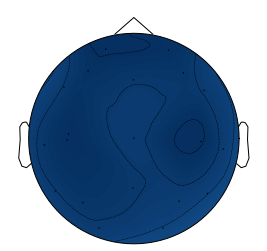

(<matplotlib.image.AxesImage at 0x7f1dbd606668>,
 <matplotlib.contour.QuadContourSet at 0x7f1dbd606320>)

In [233]:
mne.viz.plot_topomap(mean_bispectrum_vals, eeg_locs_2d)

In [187]:
y

[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]

In [168]:
eeg_locs_2d=pd.read_csv('/home/venkat/Downloads/submission/ClassifierTestsample/eeg_10_20.csv', header=None)
eeg_locs_2d

,0,1,2
0,C3,-0.3249,0.0000
1,C4,0.3249,0.0000
2,Cz,0.0000,0.0000
3,F3,-0.2744,0.3467
4,F4,0.2744,0.3467
5,F7,-0.5879,0.4270
6,F8,0.5879,0.4270
7,Fp1,-0.2245,0.6910
8,Fp2,0.2245,0.6910
9,Fpz,0.0000,0.7266


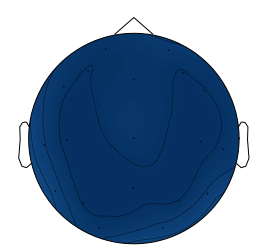

(<matplotlib.image.AxesImage at 0x7f1dbde57dd8>,
 <matplotlib.contour.QuadContourSet at 0x7f1dbde57a20>)

In [170]:
for i in range(0,19):
    allfiles1[0].info['chs'][i]['locs']=

SyntaxError: invalid syntax (<ipython-input-170-8e94d606e11f>, line 2)

In [16]:
FREQ_BANDS

{'delta': [0.5, 4.5],
 'theta': [4.5, 8.5],
 'alpha': [8.5, 11.5],
 'sigma': [11.5, 15.5],
 'beta': [15.5, 30],
 'all': [0.5, 45]}

In [17]:
FREQ_BANDS['delta']

[0.5, 4.5]

In [21]:
allfiles1[0].get_data().shape

(19, 11990)

In [23]:
signal.shape[0]

19

In [24]:
low_fq_range

array([[0.5       , 4.5       ],
       [0.57142857, 4.48979592],
       [0.64285714, 4.47959184],
       [0.71428571, 4.46938776],
       [0.78571429, 4.45918367],
       [0.85714286, 4.44897959],
       [0.92857143, 4.43877551],
       [1.        , 4.42857143],
       [1.07142857, 4.41836735],
       [1.14285714, 4.40816327],
       [1.21428571, 4.39795918],
       [1.28571429, 4.3877551 ],
       [1.35714286, 4.37755102],
       [1.42857143, 4.36734694],
       [1.5       , 4.35714286],
       [1.57142857, 4.34693878],
       [1.64285714, 4.33673469],
       [1.71428571, 4.32653061],
       [1.78571429, 4.31632653],
       [1.85714286, 4.30612245],
       [1.92857143, 4.29591837],
       [2.        , 4.28571429],
       [2.07142857, 4.2755102 ],
       [2.14285714, 4.26530612],
       [2.21428571, 4.25510204],
       [2.28571429, 4.24489796],
       [2.35714286, 4.23469388],
       [2.42857143, 4.2244898 ],
       [2.5       , 4.21428571],
       [2.57142857, 4.20408163],
       [2.

In [30]:
mean_bispectrum_vals[1,]

array([0.])

In [58]:
allfiles1[0].info

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1-AVG, F3-AVG, C3-AVG, P3-AVG, O1-AVG, Fp2-AVG, ...
    chs : list | 19 items (EEG: 19)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 19 items (19 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 19
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 200.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplo

In [171]:
eeg_locs=pd.read_csv('/home/venkat/Downloads/submission/ClassifierTestsample/10-20system.csv', header=None, thousands=',')
eeg_locs

,0,1,2
0,−21.5,70.2,−0.1
1,−35.5,49.4,32.4
2,−52.2,−16.4,57.8
3,−39.5,−76.3,47.4
4,−26.8,−100.2,12.8
5,28.4,69.1,−0.4
6,40.2,47.6,32.1
7,54.1,−18.0,57.5
8,36.8,−74.9,49.2
9,24.1,−100.5,14.1


In [140]:
eeg_locs_2d=eeg_locs.iloc[:,:2]

In [141]:
eeg_locs_2d.astype(np.float)

ValueError: could not convert string to float: '−21.5'

In [142]:
data = eeg_locs_2d.apply(pd.to_numeric, errors='coerce')

In [172]:
eeg_locs_2d=np.empty((19,2))
eeg_locs_2d[0,:]=[-21.5,70.2]
eeg_locs_2d[1,:]=[-35.5,49.4]
eeg_locs_2d[2,:]=[-52.2,-16.4]
eeg_locs_2d[3,:]=[-39.5,-76.3]
eeg_locs_2d[4,:]=[-26.8,-100.2]
eeg_locs_2d[5,:]=[28.4,69.1]
eeg_locs_2d[6,:]=[40.2,47.6]
eeg_locs_2d[7,:]=[54.1,-18.0]
eeg_locs_2d[8,:]=[36.8,-74.9]
eeg_locs_2d[9,:]=[24.1,-100.5]
eeg_locs_2d[10,:]=[-54.8,33.9]
eeg_locs_2d[11,:]=[-70.2,-21.3]
eeg_locs_2d[12,:]=[-61.5,-65.3]
eeg_locs_2d[13,:]=[56.6,30.8]
eeg_locs_2d[14,:]=[71.9,-25.2]
eeg_locs_2d[15,:]=[59.3,-67.6]
eeg_locs_2d[16,:]=[0.6,40.9]
eeg_locs_2d[17,:]=[0.8,-14.7]
eeg_locs_2d[18,:]=[0.2,-62.1]

In [150]:
np.array(eeg_locs_2d)

array([list([-21.5, 70.2]), list([-35.5, 49.4]), list([-52.2, -16.4]),
       list([-115.8]), list([-26.8, -100.2]), list([28.4, 69.1]),
       list([40.2, 47.6]), list([54.1, -18.0]), list([36.8, -74.9]),
       list([24.1, -100.5]), list([-54.8, 33.9]), list([-91.5]),
       list([-61.5, -65.3]), list([56.6, 30.8]), list([71.9, -25.2]),
       list([59.3, -67.6]), list([0.6, 40.9]),
       list([-13.899999999999999]), list([-61.9])], dtype=object)

In [ ]:
21.5	70.2	−0.1
1	−35.5	49.4	32.4
2	−52.2	−16.4	57.8
3	−39.5	−76.3	47.4
4	−26.8	−100.2	12.8
5	28.4	69.1	−0.4
6	40.2	47.6	32.1
7	54.1	−18.0	57.5
8	36.8	−74.9	49.2
9	24.1	−100.5	14.1
10	−54.8	33.9	−3.5
11	−70.2	−21.3	−10.7
12	−61.5	−65.3	1.1
13	56.6	30.8	−4.1
14	71.9	−25.2	−8.2
15	59.3	−67.6	3.8
16	0.6	40.9	53.9
17	0.8	−14.7	73.9
18	0.2	−62.1	64.5